**References:** Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a modified VAE (with a different sampling layer and a different loss function) with the instances of the normal digits in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digits in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [ ]:
nl1 = 4   # Normal digit(s)
nl2 = 4
abn1 = 8  # Abnormal digit(s)
abn2 = 8

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1) | (y_train == nl2)]        # Normal training data (Normal digits)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2)]

test_data = x_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2)]    # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn1) | (y_test == abn2) | (y_test == nl1) | (y_test == nl2)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2), True, False)
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
normal_data.shape, test_data.shape, test_labels.shape

((5842, 28, 28), (1956, 28, 28), (1956,))

In [ ]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2)]            # The normal digits in the test data
abnormal_test_data = test_data[(test_labels == abn1) | (test_labels == abn2)]        # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2)]        # Their labels
abnormal_test_labels = test_labels[(test_labels == abn1) | (test_labels == abn2)]    # Their labels

In [ ]:
normal_test_data.shape, abnormal_test_data.shape 

((982, 28, 28), (974, 28, 28))

In [ ]:
def show_reconstructions(model, images=test_data, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
K = keras.backend
# def rounded_accuracy(y_true, y_pred):
  #  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
# Modified sampling layer with the addition of mean_2, log_var_2, and ratio, with
# the appropriate change in the reparametrization trick to do stochastic 
# sampling from the superposition of the two MVN distributions, while allowing
# the 5 parallel layers containing the means and stds of the two MVNs and the ratios
# for each dimension to be trained via backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean_1, log_var_1, mean_2, log_var_2, ratio = inputs
        return (K.random_normal(tf.shape(log_var_1)) * K.exp(log_var_1 / 2) + mean_1) + (K.random_normal(tf.shape(log_var_2)) * K.exp(log_var_2 / 2) + mean_2)*ratio

In [ ]:
# For details please see Geron's book. 
codings_size = 32  # The number of dimensions of the two MVN distributions in the sampling layer

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)

# Adding output nodes (parallel layers) at the end of the encoder for means 
# and standard deviations of a second Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). In each of the dimensions,
# this second MVN is multiplied by a ratio (multiple) and added to the first MVN.
# This the ratio we want of the second MVN to be in the final superposition in
# each dimension. We could also use a factor 0 < p < 1 and let:
# final distribution = p * first MVN + (1 - p) * second MVN
# Another parallel layer (set of nodes) is added to keep and train the ratios
# in each dimension 
codings_mean_1 = keras.layers.Dense(codings_size)(z)
codings_log_var_1 = keras.layers.Dense(codings_size)(z)
codings_mean_2 = keras.layers.Dense(codings_size)(z)
codings_log_var_2 = keras.layers.Dense(codings_size)(z)
codings_ratio = keras.layers.Dense(codings_size)(z)

# Modified sampling layer at the end of the encoder
codings = Sampling()([codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_ratio])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_ratio, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, _, _, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# New latent loss function that will be added to the reconstruction binary cross-entropy loss
# The whole network (Encoder, sampling layer, and decoder) will train to minimize this loss
array1 = codings_log_var_1 - K.exp(codings_log_var_1) - K.square(codings_mean_1)
array2 = (codings_log_var_2 - K.exp(codings_log_var_2) - K.square(codings_mean_2)) # *  codings_ratio
sum1 = K.sum(1 + array1, axis=-1)
sum2 = K.sum(1 + array2, axis=-1)

latent_loss = -0.5 * tf.math.maximum(sum1, sum2)
# latent_loss = -0.5 * K.sum(1 + (array1 + array2)/(1 + codings_ratio/codings_ratio), axis=-1) 

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# For the reconstruction loss binary cross-entropy loss is used (same as regular VAE). 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=512,
                             validation_data=(test_data, test_data), shuffle=True)

(None,)
Epoch 1/100
12/12 [==============================] - 6s 150ms/step - loss: 0.4181 - val_loss: 0.2904
Epoch 2/100
12/12 [==============================] - 1s 93ms/step - loss: 0.2304 - val_loss: 0.2752
Epoch 3/100
12/12 [==============================] - 1s 86ms/step - loss: 0.2157 - val_loss: 0.2675
Epoch 4/100
12/12 [==============================] - 1s 91ms/step - loss: 0.2008 - val_loss: 0.2527
Epoch 5/100
12/12 [==============================] - 1s 87ms/step - loss: 0.1930 - val_loss: 0.2402
Epoch 6/100
12/12 [==============================] - 1s 81ms/step - loss: 0.1828 - val_loss: 0.2430
Epoch 7/100
12/12 [==============================] - 1s 84ms/step - loss: 0.1764 - val_loss: 0.2397
Epoch 8/100
12/12 [==============================] - 1s 74ms/step - loss: 0.1717 - val_loss: 0.2322
Epoch 9/100
12/12 [==============================] - 1s 80ms/step - loss: 0.1651 - val_loss: 0.2365
Epoch 10/100
12/12 [==============================] - 1s 92ms/step - loss: 0.1590 - val_los

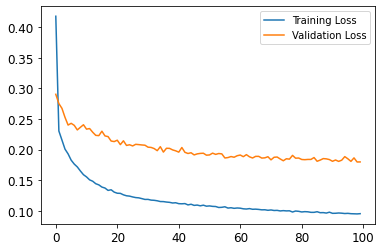

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

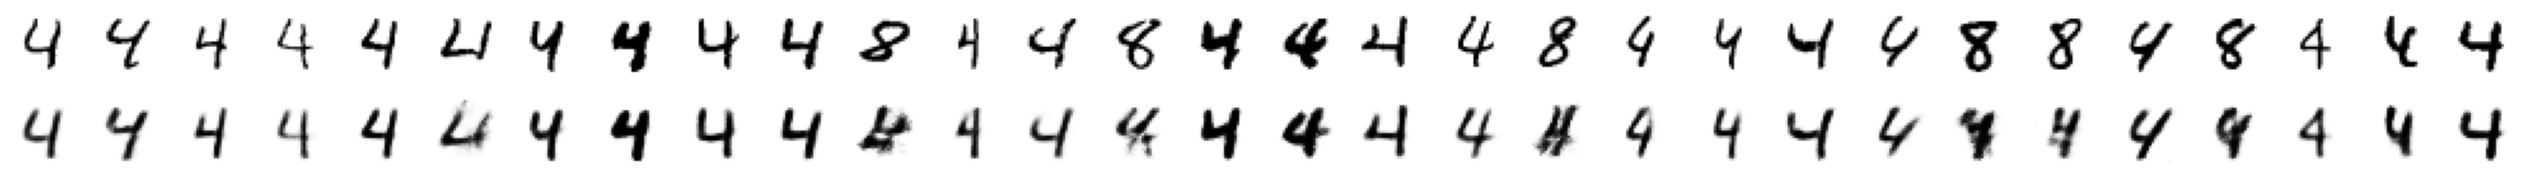

In [ ]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

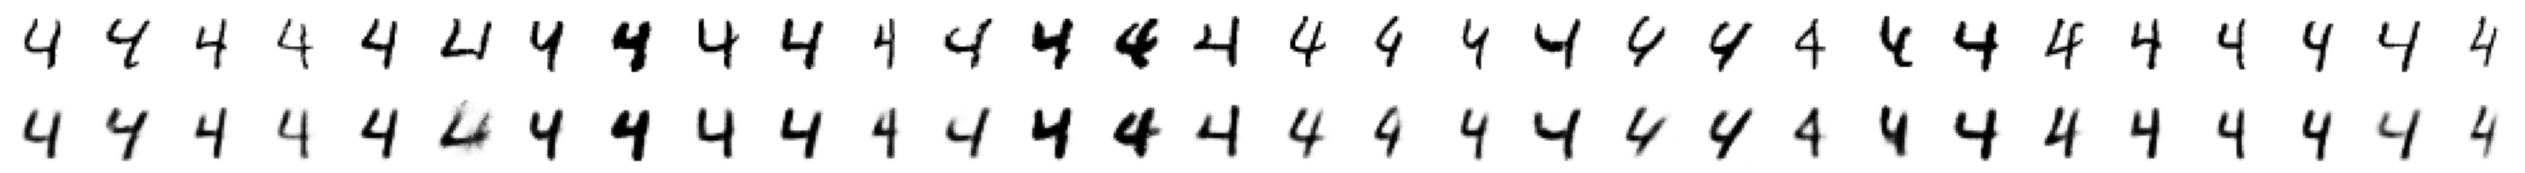

In [ ]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

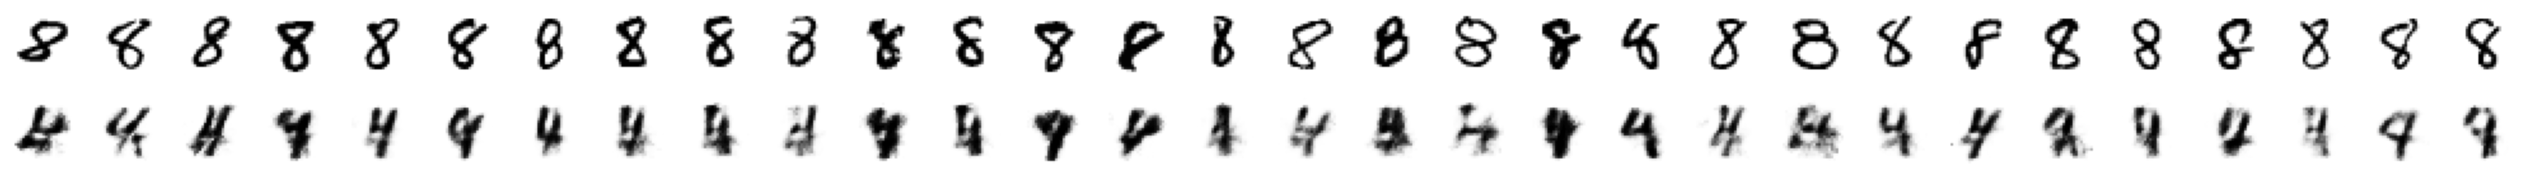

In [ ]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

In [ ]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

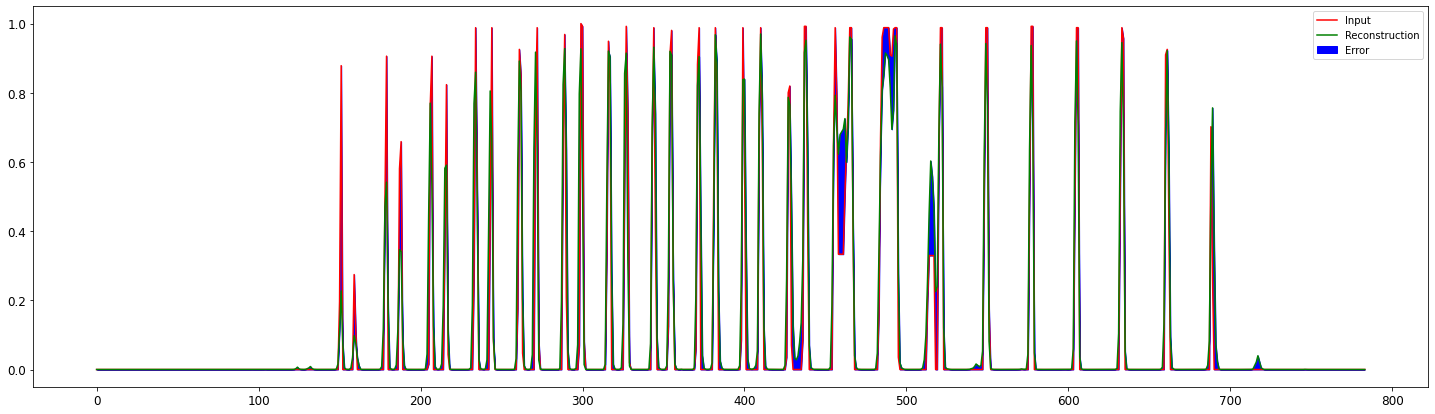

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

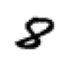

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

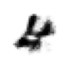

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(reconstructions_abn_test[0], cmap="binary")
plt.axis('off')
plt.show()

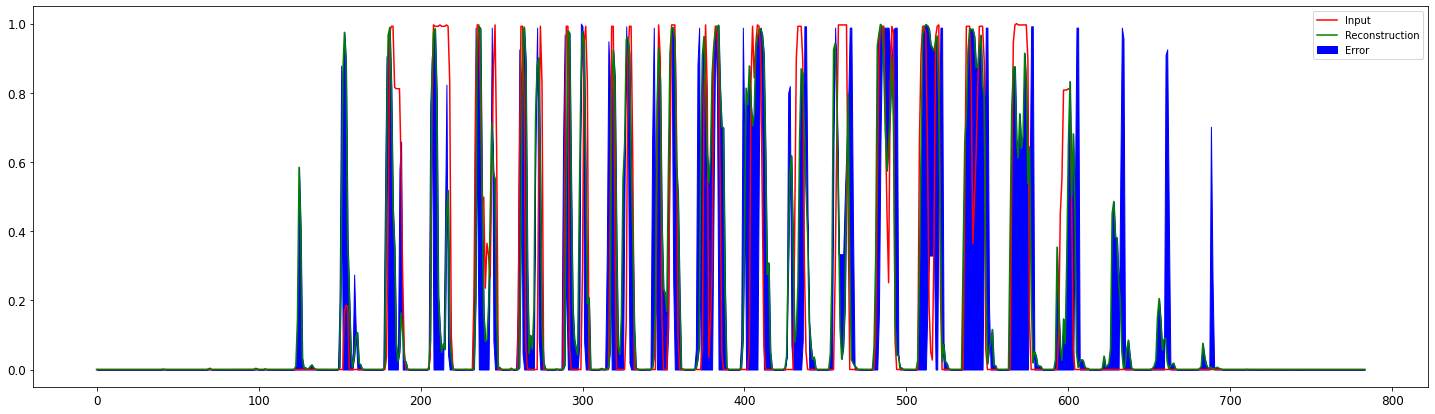

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

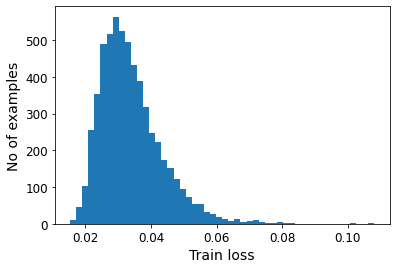

In [ ]:
reconstructions_nl_data = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions_nl_data.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.03397378
Std:  0.00944392


In [ ]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.057583579793572426


**Distribution of the reconstruction losses of the abnormal test data**

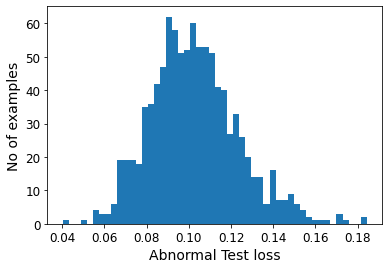

In [ ]:
abn_test_loss = tf.keras.losses.mae(reconstructions_abn_test.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Abnormal Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [ ]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.102629125, 0.020674068)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [ ]:
threshold = threshold1

**Calculation of the confusion matrix**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1001   955
 label: F   [[970   4]    974
        T    [31   951]]   982
Accuracy = 0.9821063394683026
Precision = 0.9958115183246073
Recall = 0.9684317718940937


In [ ]:
print(confusion_matrix(test_labels_T_F, preds))

[[970   4]
 [ 31 951]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

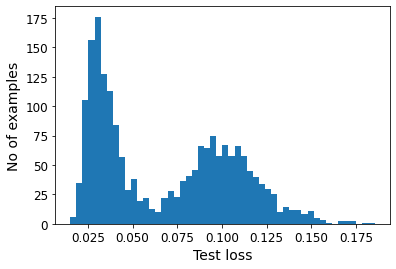

In [ ]:
reconstructions_test_data = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions_test_data.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Extra Info**

Giving the VAE codings (please see book) (Just informative, not the goal here)

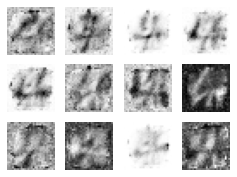

In [ ]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

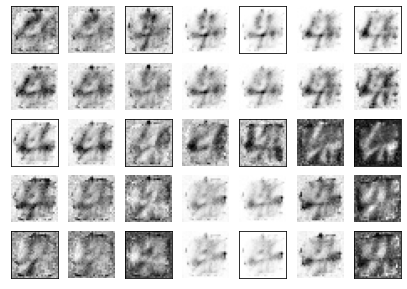

In [ ]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)